In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, brier_score_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import calibration_curve

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import data
train_df = pd.read_csv('data/Recvidism_extra_feat_train.csv')
test_df = pd.read_csv('data/Recvidism_extra_feat_test.csv')


In [2]:
# Make Recidivism_Within_3years the last column in train data
cols = [col for col in train_df.columns if col != 'Recidivism_Within_3years']
cols.append('Recidivism_Within_3years')
train_df = train_df[cols]

# Make Recidivism_Within_3years the last column in test data
cols = [col for col in test_df.columns if col != 'Recidivism_Within_3years']
cols.append('Recidivism_Within_3years')
test_df = test_df[cols]

### MLP

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): source data
        """
        # Assuming the last column is the label
        self.features = dataframe.iloc[:, :-1].values
        self.labels = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Convert features and labels to tensors
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return features, label


In [5]:
#Convert pd dataframe to torch dataset
train_dataset = DataFrameDataset(train_df)
test_dataset = DataFrameDataset(test_df)

# use 15% of training data for validation
train_set_size = int(len(train_dataset) * 0.85)
valid_set_size = len(train_dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
total_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Create fully connected layers (nn.Linear)
        ### START CODE ###
        self.fc1 = nn.Linear(65, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        ### END CODE ###

    def forward(self, x):
        ### START CODE ###
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ### END CODE ###
        return x


In [7]:
model = MLP()
# Create the optimizer
### START CODE ###
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
### END CODE ###

In [8]:
# Create the loss function instance
criterion = torch.nn.BCEWithLogitsLoss()

def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Use the optimizer to perform backpropagation
        ### START CODE ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ### END CODE ###

        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    return avg_loss

@torch.no_grad()
def eval(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Get model's prediction
        ### START CODE ###
        pred = torch.sigmoid(out) >= 0.5
        ### END CODE ###

        # Count number of correct predictions
        ### START CODE ###
        correct = (pred.float() == target.float()).sum().item()
        ### END CODE ###

        total_correct += correct
        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    acc = total_correct / total_num
    return avg_loss, acc


In [9]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, total_train_loader, optimizer)
    val_loss, val_acc = eval(model, test_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

100%|██████████| 31/31 [00:00<00:00, 452.50it/s]


Epoch: 1 Train Loss: 0.6508614767118809 Val Loss: 0.6273736417011062 Val Acc: 0.6523632637376713


100%|██████████| 31/31 [00:00<00:00, 473.14it/s]


Epoch: 2 Train Loss: 0.5975891985569504 Val Loss: 0.5823503138009085 Val Acc: 0.7001408991930319


100%|██████████| 31/31 [00:00<00:00, 452.41it/s]


Epoch: 3 Train Loss: 0.5698740303529612 Val Loss: 0.572689951725893 Val Acc: 0.7025746125272192


100%|██████████| 31/31 [00:00<00:00, 432.47it/s]


Epoch: 4 Train Loss: 0.5633188793181526 Val Loss: 0.5710588927548109 Val Acc: 0.702062251825285


100%|██████████| 31/31 [00:00<00:00, 483.01it/s]


Epoch: 5 Train Loss: 0.5598373860087711 Val Loss: 0.566447293703422 Val Acc: 0.7107723837581658


100%|██████████| 31/31 [00:00<00:00, 465.24it/s]


Epoch: 6 Train Loss: 0.5538189641937914 Val Loss: 0.5601443508087603 Val Acc: 0.7137184577942872


100%|██████████| 31/31 [00:00<00:00, 448.58it/s]


Epoch: 7 Train Loss: 0.550374803784842 Val Loss: 0.5581667004557537 Val Acc: 0.7151274497246061


100%|██████████| 31/31 [00:00<00:00, 436.58it/s]


Epoch: 8 Train Loss: 0.5491008817726369 Val Loss: 0.5562735479742582 Val Acc: 0.7184577942871782


100%|██████████| 31/31 [00:00<00:00, 440.77it/s]


Epoch: 9 Train Loss: 0.5473305579032711 Val Loss: 0.5548926502393672 Val Acc: 0.7167926220058921


100%|██████████| 31/31 [00:00<00:00, 434.19it/s]


Epoch: 10 Train Loss: 0.5447738084926398 Val Loss: 0.5643728928039485 Val Acc: 0.7142308184962214


100%|██████████| 31/31 [00:00<00:00, 493.11it/s]


Epoch: 11 Train Loss: 0.5429164501973734 Val Loss: 0.5580716955840427 Val Acc: 0.7125656462149353


100%|██████████| 31/31 [00:00<00:00, 461.81it/s]


Epoch: 12 Train Loss: 0.5414347447734306 Val Loss: 0.5571598842352594 Val Acc: 0.7106442935826822


100%|██████████| 31/31 [00:00<00:00, 458.56it/s]


Epoch: 13 Train Loss: 0.5382908769158532 Val Loss: 0.552581222029552 Val Acc: 0.7167926220058921


100%|██████████| 31/31 [00:00<00:00, 445.82it/s]


Epoch: 14 Train Loss: 0.5346959847580812 Val Loss: 0.5559231163796686 Val Acc: 0.7219162290252338


100%|██████████| 31/31 [00:00<00:00, 442.67it/s]

Epoch: 15 Train Loss: 0.5346450197781325 Val Loss: 0.5538763517421538 Val Acc: 0.716536441654925


In [10]:
@torch.no_grad()
def get_predictions(model, loader):
    model.eval()
    all_probs = []
    all_targets = []
    all_preds = []

    for data, target in loader:
        out = model(data)
        prob = torch.sigmoid(out)
        all_probs.extend(prob.view(-1).cpu().numpy())
        all_preds.extend((prob >= 0.5).long().view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    return all_probs, all_targets, all_preds

# Calculate probabilities and actual labels on the test set
all_probs, all_targets, all_preds = get_predictions(model, test_loader)

# Now, you can calculate the Brier score
brier_score = brier_score_loss(all_targets, all_probs)
print(f"Brier Score: {brier_score:.4f}")


Brier Score: 0.1872


ROC AUC: 0.7797


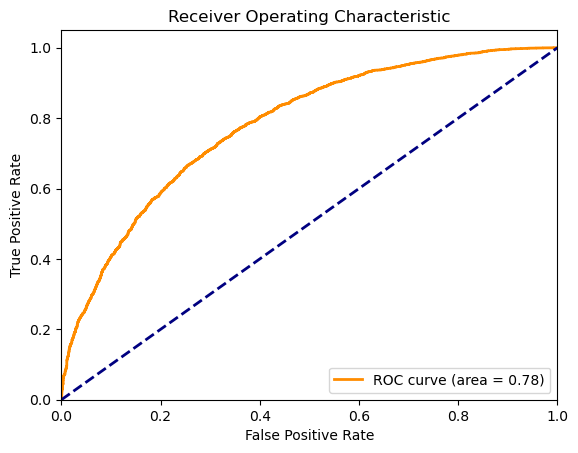

In [11]:
# Calculate ROC AUC
roc_auc = roc_auc_score(all_targets, all_probs)
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


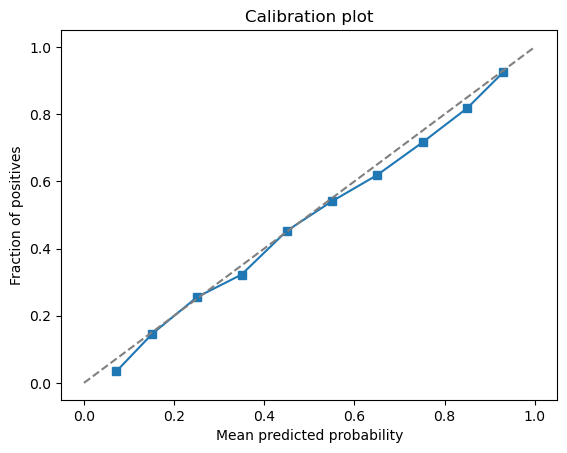

In [12]:
# Calculate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(all_targets, all_probs, n_bins=10)

# Plot calibration plot
plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.show()


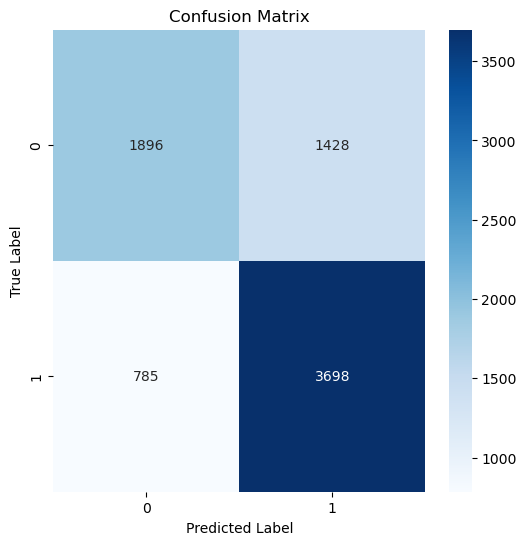

In [13]:
# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()